# Simulación numérica | Máquina de Atwood

[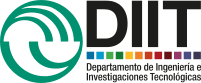](https://ingenieria.unlam.edu.ar/)    
[by-nc-sa_80x15.png](https://creativecommons.org/licenses/by-sa/4.0/deed.es_ES) 
2021 [Víctor A. Bettachini](mailto:vbettachini@unlam.edu.ar)  

---

## Parámetros de simulación
Rango de tiempo \\(t = 0 - 10\,\mathrm{s}\\).  
Parámetros físicos y condiciones iniciales:  
\\(\ell_\mathrm{cuerda} > 150\,\mathrm{m}\\),
\\(R_{\mathrm{polea}} = 0.5\,\mathrm{m}\\),  
\\(m_1 = 2\,\mathrm{kg}\\),
\\(m_2 = 1\,\mathrm{kg}\\),
\\(m_\mathrm{polea} = 4\,\mathrm{kg}\\),  
\\(x(t=0) = 25\,\mathrm{m}\\),
\\(\dot{x}(t=0) = -10\,\mathrm{m\,s^{-2}}\\).
 
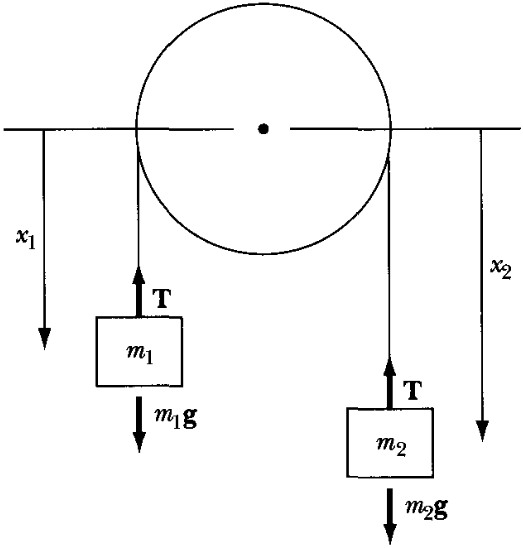

## Resolución simbólica en el formalismo Lagrangiano
A continuación se obtiene la ecuación Lagrangiana, sino que también se resolverá la correspondiente de Euler-Lagrange con las funciones del módulo `sympy`.

In [1]:
import sympy as sym # módulo de cálculo simbólico
from sympy.physics import mechanics as mech
mech.init_vprinting() # notación con punto para la velocidad y punto punto para la aceleración
import warnings
warnings.filterwarnings("ignore")

### Variables

In [2]:
# Defino los parámetros físicos del sistema
M, R, m1, m2, g, l = sym.symbols('M, R, m_1, m_2, g, \ell', positive=True)

t = sym.symbols('t') # tiempo
n = mech.ReferenceFrame('n') # sistema de coordenadas

### Ligadura
La cuerda inextensible establece una ligadura entre las coordenadas de ambas partículas que cuelgan de la polea.
- La cuerda de longitud $l$ impone $x_1+ x_2 + \pi R = \ell$ siendo $R$ el radio de la polea que se la considera sin masa.
- De las dos coordenadas generalizadas: $x_1,x_2$ la existencia de una función de ligadura hace que solo se requiera.
- Se escribe tala relación como una función homogénea (igualada al valor nulo $0$)
$$
f_1(x_1, x_2) = x_1+ x_2 + \pi R - \ell = 0
$$ 

In [3]:
# Defino coordenadas generalizadas 
x1 = mech.dynamicsymbols('x_1')
x2 = mech.dynamicsymbols('x_2')

# Ligaduras
f1 = x1+ x2 + sym.pi* R - l # ligadura l como función homogénea
f1

In [4]:
x2_f1 =  sym.solveset(f1, x2).args[0]
sym.Eq(x2, x2_f1)

### Posiciones en función de coordenas generalizadas

In [5]:
m1_r = x1* (-n.y) # versor y para arriba
m2_r = x2_f1* (-n.y) # resto longitud hilo x1 y media vuelta polea
m1_r, m2_r

### Energía cinética

In [6]:
# velocidad
m1_v = m1_r.diff(t, n) # se indica que se deriva en sistema de referencia o
m2_v = m2_r.diff(t, n) # se indida que se deriva en sistema de referencia o
m1_v, m2_v

In [7]:
# velocidad al cuadrado
m1_v2 = m1_v.dot(m1_v) # vector producto punto con sigo mismo
m2_v2 = m2_v.dot(m2_v) # vector producto punto con sigo mismo
m1_v2, m2_v2

In [8]:
# Energía cinética
unMedio = sym.Rational(1,2) # Rational: fracción de enteros, alternativamente podría haberse usado 0.5 
T_m1 = unMedio* m1* m1_v2
T_m2 = unMedio* m2* m1_v2
T = sym.Eq(sym.Symbol('T'), (T_m1 + T_m2).simplify() ) # simplify: simplifica usando factor común y otras operaciones
T

### Energía potencial

In [9]:
# Energía potencial
g_vector = g* (-n.y) # aceleración gravitatoria en -y versor
V_m1 = m1* (-g_vector).dot(m1_r)
V_m2 = m2* (-g_vector).dot(m2_r)
V = sym.Eq(sym.Symbol('V'), (V_m1 + V_m2).simplify() )
V

### Lagrangiano
$$
\mathcal{L}(x_1, \dot{x}_1) = T(\dot{x}_1)- V(x_1)
$$

In [10]:
L = sym.Eq(sym.Symbol('\mathcal{L}'), T.rhs - V.rhs).simplify()
L

## Ecuación de Euler-Lagrange

In [11]:
variable = x1
x1_EL = sym.Eq(L.rhs.diff(variable) - L.rhs.diff(variable.diff(t)).diff(t), 0 ).simplify() # ecuación igualando a cero
x1_EL

Esta es una ecuación diferencial lineal de segundo orden homogena.
De aquí se puede despejar $\ddot{x}$

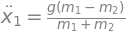

In [15]:
x_pp = sym.Eq(x1.diff(t,2),
       list( sym.solveset(x1_EL, x1.diff(t,2) ) )[0]  # solveset devuelve un set, que convertimos a lista
      )
x_pp # aceleración = x punto punto [m s-2]

## Resolución analítica de la ecuación de Euler-Lagrange

Resolver analíticamente esta ecuación es sencillo.
Basta con integrar dos veces en el tiempo esta $\ddot{x}$ para obtener $x(t)$ 

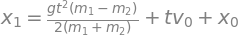

In [17]:
x_0, v_0 = sym.symbols('x_0 v_0')
sym.Eq(x1, unMedio* x_pp.rhs* t**2+ v_0* t + x_0)

En este caso de un sistema mecánico muy simple hacer una resolución analítica de una ecuación de Euler-Lagrange, que es una ecuación diferencial ordinaria (ODE en inglés) resultó trivial.

Pero hacer esto en sistemas mecánicos complejos puede ser engorroso o inclusive imposible.
Por esa razón exploraremos la alternativa que es la **resolución numérica** .

## Resolución numérica de ecuaciones diferenciales

### Esquema de Euler
No es difícil de probar que posiciones en tiempos sucesivos $x(t_i)$, $x(t_{i+1})$ están relacionadas por la velocidad en algún tiempo intermedio
$$
x(t_{i+1}) 
= x(t_i) + \frac{\partial x}{\partial t}\bigg|_{t_i \leq t \leq t_{i+1}} (t_{i+1} - t_i).
= x(t_i) + \dot{x}|_{t_i \leq t \leq t_{i+1}} (t_{i+1} - t_i).
$$

El esquema de Euler para la integración numérica se basa en que si $(t_{i+1} - t_i) \ll 1$ el error que se comete de usar la velocidad en $t_i$ es pequeño
$$
x(t_{i+1}) \simeq x(t_i) + \dot{x}(t_i) (t_{i+1} - t_i).
$$
Luego es cuestión de calcular $\dot{x}(t_{i+1})$ y se puede avanzar a $x(t_{i+2})$.
Y así sucesivamente habiendo partido de unas condiciones iniciales
- $x(t_0)$
- $\dot{x}(t_0)$

### Vector de estado en $t_i$

Los métodos numéricos más eficientes trabajan sobre una ecuación diferencial de primer orden.
Para utilizarlos se reduce la ecuación de la dinámica, una **ecuación diferencial ordinaria de 2.o orden**, a un **sistema de dos ecuaciones de 1.er orden**.

Esto métodos actualizan un vector de estado del sistema 
$$
\vec{y}_i 
= \begin{vmatrix}
y_{0,i}\\
y_{1,i}
\end{vmatrix}
= \begin{vmatrix}
x_i\\
\dot{x}_i
\end{vmatrix}
$$
en cortos intervalos tiempo $\Delta t_i = t_{i+1} - t_i$ 
$$
\vec{y}_{i+1} = \vec{y}_i + \dot{\vec{y}}_n(t_i) \Delta t_i,
$$
donde en
$$
\dot{\vec{y}}_i = 
\begin{vmatrix}
\dot{x}_i \\
\ddot{x}_i
\end{vmatrix}
$$
figuran los $\ddot{x}_i$ que son las **aceleraciones generalizadas** que despejamos de la ecuaciones de Euler-Lagrange.

$$
\left\{
\begin{array}{l}
y_{0,i} = x_i\\
y_{1,i} = \dot{y}_{0,i} =  \dot{x}_i\\
\dot{y}_{1,i} = \ddot{y}_{0,i} = \ddot{x}_i = g \frac{(m1 - m_2)}{m_1 + m_2}\\
\end{array}
\right. ,
$$

En el caso de este sistema $\ddot{x}_i \equiv \mathrm{constaste}$.
En un caso general la aceleración puede ser función de $t_i, x_i, \dot{x}_i$.

Lo que optimizan estos métodos numéricos, por sobre un esquema simple de Euler, es optimizar $\Delta t_i$ para que el error se mantenga debajo de una magnitud indicada.

> Referencia:  
> - https://pundit.pratt.duke.edu/wiki/Python:Ordinary_Differential_Equations/Examples
> - http://sam-dolan.staff.shef.ac.uk/mas212/notebooks/ODE_Example.html
> - https://ipython-books.github.io/123-simulating-an-ordinary-differential-equation-with-scipy/

### Valores numéricos

Necesitamos establecer la magnitud de $\ddot{x}$, esto es cuantos $\mathrm{\frac{m}{s^2}}$, en función de los parámetros físicos del sistema.

In [21]:
# parámetros_físicos
g_magnitud = 9.81 # [m s-2]
m_1_magnitud = 2 # [kg]
m_2_magnitud = 1 # [kg]
magnitudes = {
    g : g_magnitud,
    m1 : m_1_magnitud,
    m2 : m_2_magnitud,
}
x1_pp_valores = x_pp.subs(magnitudes)
x1_pp_valores # [m s-2]

In [22]:
type(x_pp_valores)

sympy.core.relational.Equality

Lo anterior es una expresión `sympy`.
Para hacer cálculos con ella necesito poner su magnitud en una expresión que pueda interpretarse fuera de este módulo.
Para esto se usa el comando `lambdify` que retorna la función en un formato compatible con el módulo de Python indicado.
Por defecto este módulo es el `numpy` que es la que usaremos a continuación.
Obligatoriamente hay que indicar al menos una variable de la que depende la función.
En este caso se indicó $t$ aunque realmente no figura en $\ddot{x}$. 

In [23]:
x_pp_numpy = sym.lambdify(t, x_pp_valores.rhs)
x_pp_numpy = x_pp_numpy(9999) # el valor de t no afecta nada, pero debe indicarse uno
x_pp_numpy # [m s-2]

In [24]:
type(x_pp_numpy)

float

### Condiciones iniciales
Ahora defino condiciones iniciales del sistema y el rango de tiempo a analizar 

In [25]:
# biblioteca de cálculo numérico general
import numpy as np

In [26]:
y_inicial = [25, -10] # [unidades SI] posicion, velocidad, en el mismo orden que en vector estado
t_rango = np.linspace(0, 10, 100) # tiempos inicial,final y cuantos tiempos intermedios equiespaciados

E integramos en los pasos de tiempo de `t_rango`.

> Referencia:
> - https://docs.scipy.org/doc/scipy-1.1.0/reference/tutorial/integrate.html

In [27]:
# biblioteca de cálculo científico: eficientes herramientas de cálculo numérico
# Importo la función solve_ivp: resolver un sistema de ODEs con condiciones iniciales
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp

In [28]:
# defino una función con el sistema de derivadas
# t : no se usa en este sistema pero lo dejamos para uso posterior
# y : lista de estado con [y_0, y_1]
# constantes : lista de constates, en este caso tendrá g(m1-m2)/(m1+m2)
# dx_dt : lista de derivadas
def y_punto(t, y):
    velocidad = y[1] # 2.o elemento del vector de estado
    aceleracion = x_pp_numpy
    dy_dt = [velocidad, aceleracion]
    return dy_dt

In [29]:
# Integración de a pasos en el tiempo
y_ode2 = solve_ivp(y_punto, (t_rango[0], t_rango[-1] ), y_inicial, t_eval = t_rango)

In [30]:
y_ode2

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.6565656

Aquí se ve que `y_ode2.t` son los tiempos en que se hicieron los puntos intermedios según $\Delta t_i$ dentro de `t_rango`. 

Los resultados de la integracíon están en `y_ode2.y`. Las $x(t)$ en `y_ode2.y[0]` y las $\dot{x}(t)$ en `y_ode2.y[1]`.

## Graficación

In [31]:
# biblioteca de graficación
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

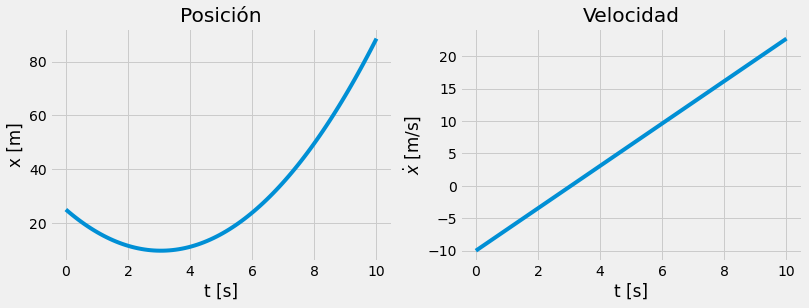

In [32]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, squeeze=False, figsize=(12, 4)) # dos figuras en la misma fila
ax[0,0].set(xlabel='t [s]', ylabel='x [m]', title='Posición')
ax[0,0].plot(y_ode2.t, y_ode2.y[0]) # fila 0 columna 0
ax[0,1].set(xlabel='t [s]', ylabel='$\dot{x}$ [m/s]', title='Velocidad')
ax[0,1].plot(y_ode2.t, y_ode2.y[1]) # fila 0 columna 1

### Error del método numérico
Comparemos con la solución analítica

Defino funciones que calculan la posición y velocidad a partir de la $\ddot{x}$ despejada de la ecuación de Euler-Lagrange. 

In [33]:
def x_mruv(a, v_0, x_0, t):
    return 0.5* a* t**2 + v_0* t + x_0

def v_mruv(a, v_0, t):
    return a* t + v_0

Y grafico la solución numérica, la analítica y su diferencia para evaluar el error de la primera.

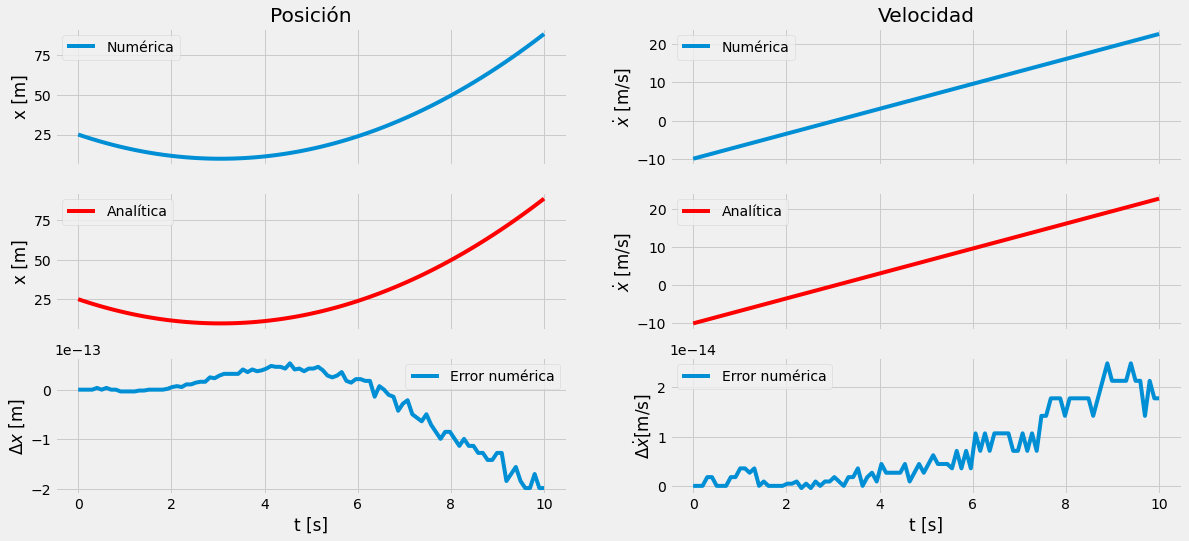

In [34]:
fig, ax = plt.subplots(nrows= 3, ncols= 2, figsize=(18, 8), sharex= True) # dos figuras en la misma fila

ax[0,0].set(ylabel='x [m]', title='Posición')
ax[0,0].plot(y_ode2.t, y_ode2.y[0], label='Numérica') # fila 0 columna 0
ax[0,0].legend()

ax[1,0].set(ylabel='x [m]')
ax[1,0].plot(y_ode2.t, x_mruv(x_pp_numpy, y_inicial[1], y_inicial[0], y_ode2.t), 'r', label='Analítica') # fila 0 columna 0
ax[1,0].legend()

ax[2,0].set(xlabel='t [s]', ylabel='$\Delta x$ [m]')
ax[2,0].plot(y_ode2.t, y_ode2.y[0] - x_mruv(x_pp_numpy, y_inicial[1], y_inicial[0], y_ode2.t), label='Error numérica') # fila 0 columna 0
ax[2,0].legend()

ax[0,1].set(ylabel='$\dot{x}$ [m/s]', title='Velocidad')
ax[0,1].plot(y_ode2.t, y_ode2.y[1], label='Numérica') # fila 0 columna 1
ax[0,1].legend()

ax[1,1].set(ylabel='$\dot{x}$ [m/s]')
ax[1,1].plot(y_ode2.t, v_mruv(x_pp_numpy, y_inicial[1], y_ode2.t), 'r', label='Analítica') # fila 0 columna 0
ax[1,1].legend()

ax[2,1].set(xlabel='t [s]', ylabel='$\Delta \dot{x}$[m/s]')
ax[2,1].plot(y_ode2.t, y_ode2.y[1] - v_mruv(x_pp_numpy, y_inicial[1], y_ode2.t), label='Error numérica') # fila 0 columna 0
ax[2,1].legend()

El algorítmo de integración mantiene el error de $x$ dentro de un tolerancia. 
La cota de este puede ajustarse para que se modifique en cada $\Delta t_i$ la predicción de $\dot{x}$
Por eso esta última va _acumulando_ error, pero su magnitud es despreciable.